# Pre-processing pipeline for openephys sessions, starling
- For every run in the session:
 - Load the recordings
 - Extract wav chan with micrhopohone and make a wav chan with the nidq syn signal
 - Get the sync events for the nidq sync channel
 
 - Do bout detection
 
In another notebook, bout detection is curated
- Left to decide where to:
    - Sort spikes
    - Sync the spikes/lfp/nidq
    - make and plot 'bout rasters'

In [1]:
%matplotlib inline
import os
import glob
import logging
import pickle
import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy import signal
import traceback
import warnings
import json

from matplotlib import pyplot as plt
from importlib import reload

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)


In [2]:
from ceciestunepipe.file import bcistructure as et
from ceciestunepipe.util import sglxutil as sglu
from ceciestunepipe.util import oelegacy as oel
from ceciestunepipe.util import rigutil as ru
from ceciestunepipe.util import wavutil as wu
from ceciestunepipe.util import syncutil as su
from ceciestunepipe.util import fileutil as fu

from ceciestunepipe.util.sound import boutsearch as bs
from ceciestunepipe.util.sound import spectral as sp

from ceciestunepipe.pipeline import searchbout as sb

from ceciestunepipe.util.spikeextractors import preprocess as pre


In [3]:
from spikeinterface import core as sc

import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.widgets as sw
logger.info('all modules loaded')

2022-09-02 08:55:54,829 root         INFO     all modules loaded


## Session parameters and raw files

#### list all the sessions for this bird

In [4]:
bird = 's_b1312_22'
all_bird_sess = et.list_sessions(bird)
logger.info('all sessions for bird are {}'.format(all_bird_sess))

2022-09-02 08:55:54,856 root         INFO     all sessions for bird are ['2022-08-30']


### set up bird and sessions parameters
this will define:
- locations of files (for the bird)
- signals and channels to look for in the metadata of the files and in the rig.json parameter file: Note that this have to exist in all of the sessions that will be processed
- 'sess' is unimportant here, but it comes handy if there is need to debug usin a single session

In [5]:
reload(et)
# for one example session

sess_par = {'bird': bird,
           'sess': '2022-08-30',
           'probes': ['probe_0'], #probes of interest
           'mic_list': ['led_intensity_0'], #list of mics of interest, by signal name in rig.json
           'sort': 0, #label for this sort instance
            
            'processor': 'Acquisition_Board-100.Rhythm Data',
            'record_node': 'Record Node 101',
            'experiment': 'experiment1',
           }

exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sort=sess_par['sort'], ephys_software='oe')

ksort_folder = exp_struct['folders']['ksort']
raw_folder = exp_struct['folders']['oe']

list all the epochs in a session, to check that it is finding what it has to find

In [6]:
import json

In [7]:
# this should go to eciestunepipe.file.bcistructure (as et here)
def list_oe_epochs(exp_struct):
    sess_path = os.path.join(exp_struct['folders']['oe'])
    epoch_list = [os.path.split(f.path)[-1] for f in os.scandir(sess_path) if f.is_dir()]
    return epoch_list

def list_nodes(epoch_path):
    return [f.path for f in os.scandir(epoch_path) if f.is_dir()]

def list_experiments(node_path):
    return [f.path for f in os.scandir(node_path) if f.is_dir()]

def list_recordings(experiment_path):
    return [f.path for f in os.scandir(experiment_path) if f.is_dir()]

def list_processors(signal_path):
    return [f.path for f in os.scandir(signal_path) if f.is_dir()]

def get_rec_meta(rec_path):
    rec_meta_path = os.path.join(rec_path, 'structure.oebin')
    with open(rec_meta_path, 'r') as meta_file:
        meta = json.load(meta_file)
    return meta

def get_continous_files_list(rec_path, processor='Rhythm_FPGA-100.0'):
    cont_raw_list = glob.glob(os.path.join(rec_path, 'continuous', processor, 'continuous.dat'))
    return cont_raw_list

def oe_list_bin_files(epoch_path):
    return glob.glob(os.path.join(epoch_path, 'experiment*.dat'))

def get_default_node(exp_struct, epoch, rec_index=0):
    # get the first rec node, the first experiment, and ith index of recording
    r_path = os.path.join(os.path.join(exp_struct['folders']['oe'], epoch))
    node = list_nodes(r_path)[0]
    
    r_path = os.path.join(r_path, node)
    experiment = list_experiments(r_path)[0]
    
    return r_path

def get_default_recording(node_path):
    experiment = list_experiments(node_path)[0]
    r_path = os.path.join(node_path, experiment)
    
    recording = list_recordings(r_path)[0]
    r_path = os.path.join(r_path, recording)
    return r_path

def get_default_continuous(rec_path):
    processor = list_processors(os.path.join(rec_path, 'continuous'))[0]
    r_path = os.path.join(rec_path, processor)
    return r_path

In [8]:
def get_oe_sample_rate(rec_meta_dict: dict) -> float:
    return float(rec_meta_dict['continuous'][0]['sample_rate'])


def build_chan_info_pd(oe_meta_dict: dict, processor_order: int=0) -> pd.DataFrame:
    # read all channels names, numbers, and whether they were recorded
    rec_chan_meta = oe_meta_dict['continuous'][processor_order]['channels']
    
    all_chan_meta = []
    for i, a_chan_meta in enumerate(rec_chan_meta):
        all_chan_meta.append({'number': i,
                              'recorded': 1,
                             'name': a_chan_meta['channel_name'],
                             'gain': float(a_chan_meta['bit_volts'])})
        
    all_chan_pd = pd.DataFrame(all_chan_meta)
    return all_chan_pd

def find_chan_order(chan_info_pd: pd.DataFrame, chan_name: str) -> int:
    recorded_block_pd = chan_info_pd[chan_info_pd['recorded']==1]
    recorded_block_pd.reset_index(inplace=True, drop=True)
    return recorded_block_pd[recorded_block_pd['name']==chan_name].index[0]

In [9]:
sess_epochs = list_oe_epochs(exp_struct)
sess_epochs

['2690R210A250z_2022-08-30_14-06-31_3v3',
 '2590R670A380z_2022-08-30_13-08-30_2v3',
 '2570R550A750_2022-08-30_12-04-20_1V5',
 '3190R320A520z_2022-08-30_16-27-58_2v4',
 '2590R670A1150z_2022-08-30_13-30-29_2v3',
 '2590R670A1150z_2022-08-30_13-29-44_2v3',
 '2690R210A690z_2022-08-30_14-39-47_2v0',
 '2570R550A750_2022-08-30_11-35-04_2V4',
 '3000R320A665z_2022-08-30_15-59-06_2v6']

In [10]:
epoch = sess_epochs[8] # 2 may have had somethng tini?

epoch_path = os.path.join(raw_folder, epoch)
epoch_path

'/mnt/sphere/speech_bci/raw_data/s_b1312_22/2022-08-30/oe/3000R320A665z_2022-08-30_15-59-06_2v6'

## read the openephys data format, because yes I was that stupid.

In [11]:
import spikeinterface.extractors as se

oe_folder = os.path.join(epoch_path, 'Record Node 106')

In [12]:
oe_dict = oel.loadFolder(oe_folder)

Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
L

In [13]:
ch_names = np.array(list(oe_dict.keys()))
chan_list = np.array([int(x.split('_')[-1]) for x in ch_names])
np.argsort(chan_list)
sorted_chan_list = ch_names[np.argsort(chan_list)]

In [14]:
## get the data into an array and into a rec
s_f = int(oe_dict[ch_names[0]]['header']['sampleRate'])

data_arr = np.vstack([oe_dict[c]['data'] for c in sorted_chan_list])
t_block = np.arange(1024)
data_t = np.hstack([t_block + t_i for t_i in oe_dict[sorted_chan_list[0]]['timestamps']]).astype(int)
oe_rec = sc.numpyextractors.NumpyRecording(data_arr.T, s_f, channel_ids=sorted_chan_list)

### get the events

In [15]:
oe_evt_dict = oel.loadEvents(os.path.join(oe_folder, 'all_channels.events'))
keys_to_df = ['channel', 'timestamps', 'eventType', 'eventId', '']
oe_evt_df = pd.DataFrame.from_dict({k: v for k, v in oe_evt_dict.items() if k in keys_to_df})

loading events...


In [16]:
oe_evt_df

,channel,timestamps,eventType,eventId
0,3.0,70378023.0,3.0,1.0
1,3.0,70423055.0,3.0,0.0
2,3.0,71040698.0,3.0,1.0
3,3.0,71085730.0,3.0,0.0
4,3.0,71598073.0,3.0,1.0
...,...,...,...,...
92,3.0,99319347.0,3.0,1.0
93,3.0,99364379.0,3.0,0.0
94,3.0,99453797.0,3.0,1.0
95,3.0,99498829.0,3.0,0.0


In [17]:
# get onsets/onsets
ev_ttl_chan = 3
ch_filter = oe_evt_df['channel']==ev_ttl_chan

all_on_arr = oe_evt_df.loc[ch_filter & (oe_evt_df['eventId']==1), 'timestamps'].to_numpy().astype(int)
all_off_arr = oe_evt_df.loc[ch_filter & (oe_evt_df['eventId']==0), 'timestamps'].to_numpy().astype(int)

if all_on_arr[-1] > all_off_arr[-1]:
    all_on_arr = all_on_arr[:-1]

off_arr = np.array([all_off_arr[all_off_arr>x][0] for x in all_on_arr])
onoff_arr = np.vstack([all_on_arr, off_arr]).astype(int).T

#### get the triggers for the ttl

In [18]:
## get the start timestamps and unique duration within the recording (index in data_t)
on_idx = np.array([np.where(data_t==x)[0][0] for x in onoff_arr[:, 0]])
off_idx = np.array([np.where(data_t==x)[0][0] for x in onoff_arr[:, 1]])

led_df = pd.DataFrame(np.vstack([onoff_arr.T, on_idx, off_idx]).T, 
                     columns=['t_on', 't_off', 'idx_on', 'idx_off'])
led_df['len'] = led_df['idx_off'] - led_df['idx_on']

In [19]:
led_df

,t_on,t_off,idx_on,idx_off,len
0,70378023,70423055,262951,307983,45032
1,71040698,71085730,925626,970658,45032
2,71598073,71643105,1483001,1528033,45032
3,72219099,72264131,2104027,2149059,45032
4,72815121,72860153,2700049,2745081,45032
5,73411277,73456309,3296205,3341237,45032
6,73928394,73973426,3813322,3858354,45032
7,74496925,74541957,4381853,4426885,45032
8,75036196,75081228,4921124,4966156,45032
9,75553278,75598310,5438206,5483238,45032


In [20]:
led_df = led_df.drop([0])

#### just get all neural channels for these boundaries

In [21]:
data_arr.shape

(40, 38672384)

In [22]:
## collect all the epochs into the datafram
pre_sec = -2
post_sec = 2

pre_samp = int(s_f * pre_sec)
post_samp = int(s_f * post_sec)
len_samp = int(np.median(np.diff(onoff_arr)))
post_samp += len_samp

led_df['streams'] = led_df['idx_on'].apply(lambda x: data_arr[:32, x + pre_samp: x + post_samp])




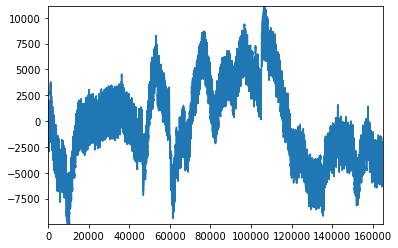

In [23]:
plt.plot((led_df.loc[2, 'streams']).sum(axis=0))

In [24]:
np.stack(led_df['streams'], axis=0).shape

(47, 32, 165032)

In [25]:
# all averages
all_stream_arr = np.stack(led_df['streams'], axis=0)

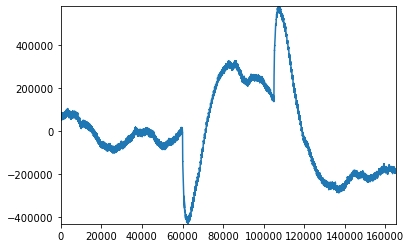

In [26]:
plt.plot((all_stream_arr).sum(axis=(0, 1)))

### apply a filter, see some channels, etcetera

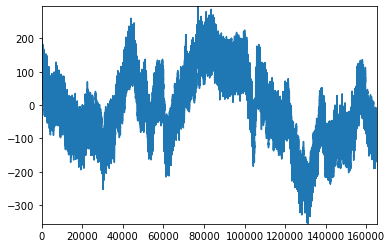

In [27]:
plt.plot(all_stream_arr[0, 5,:])

In [28]:
all_stream_arr.shape

(47, 32, 165032)

In [29]:
filt_pars = sp.make_butter_bandpass(s_f, 300, 12500)
all_stream_arr_filt = sp.apply_butter_bandpass(all_stream_arr, filt_pars, axis=-1)

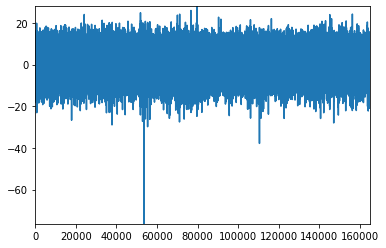

In [30]:
plt.plot(all_stream_arr_filt[0, 0,:])

In [31]:
(all_stream_arr_filt).sum(axis=(0)).shape

(32, 165032)

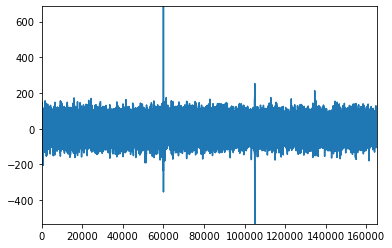

In [32]:
plt.plot((all_stream_arr_filt).sum(axis=(0))[6])

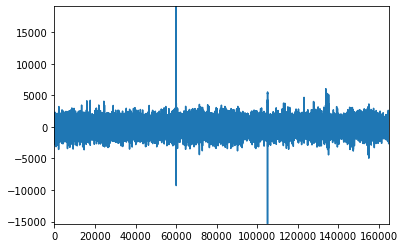

In [33]:
plt.plot((all_stream_arr_filt).sum(axis=(0, 1)))

In [34]:
raise KeyboardInterrupt

KeyboardInterrupt: 

# quick and dirty, do my thing and se the binary recording

In [ ]:
class oeRecordingExtractor(se.BinDatRecordingExtractor):
    extractor_name = 'oeContinuousRecordingExtractor'
    has_default_locations = True
    installed = True  # check at class level if installed or not
    is_writable = False
    mode = 'file'
    # error message when not installed
    installation_mesg = "To use the SpikeGLXRecordingExtractor run:\n\n pip install mtscomp\n\n"

    _ttl_events = None  # The ttl events
    _t_0 = None # time computed naively (n/s_f_0)
    _t_prime = None # time synchronized to a pattern ('master') reference
    _s_f_0 = None # measured samplin rate (using the syn signal)
    _syn_chan_id = None # digital channel for signal id (for nidaq; automatic last channel in lf/ap streams)
    _dig = None # the digital signal
    _start_sample = None # start sample from the beginning of the run
    _start_t = None # start t (absolute in the machine)
    
    _meta_dict = None # dictionary with metadata of the recording
    _chan_pd = None # pandas dataframe with channel ids
    
    def __init__(self, rec_path: str, processor, dtype: str = 'int16', syn_chan_id=0):
        # dtype should come from the meta but for now its ok
        # rec_path is the path to the recording
        self._meta_dict = get_rec_meta(rec_path)
        self._chan_pd = build_chan_info_pd(self._meta_dict)
        self._s_f_0 = get_oe_sample_rate(self._meta_dict)
        
        cont_path = os.path.join(rec_path, 'continuous', processor, 'continuous.dat')
        
        n_chan = self._chan_pd['recorded'].sum()
        se.BinDatRecordingExtractor.__init__(self, cont_path, self._s_f_0, n_chan, np.int16)
        
        self._chan_names = np.array(self._chan_pd .loc[self._chan_pd ['recorded']==True, 'name'])

In [ ]:
oe_recording = oeRecordingExtractor(rec_path, 'Acquisition_Board-100.Rhythm Data')

In [ ]:
list_processors(rec_path)

#### define pre-processing steps for each epoch and for the session

In [ ]:
def chan_to_wav(single_bin_path, chan_name, oe_meta_dict, wav_path):
    # get the file n of channels
    chan_info_pd = build_chan_info_pd(oe_meta_dict)
    n_channels = chan_info_pd['recorded'].sum()
    logger.info(n_channels)
    chan_pos = find_chan_order(chan_info_pd, chan_name)
    logger.info(chan_pos)
    # read the file
    bin_fp = np.memmap(single_bin_path, dtype='<i2', mode='r').reshape(-1, n_channels)
    
    #save as wav
    sample_rate = int(get_oe_sample_rate(oe_meta_dict))
    logger.info('writing wave file {}'.format(wav_path))
    wavfile.write(wav_path, sample_rate, bin_fp.T[chan_pos])

In [ ]:
def preprocess_run(sess_par: dict, exp_struct: dict, epoch:str, do_sync_to_stream=None) -> dict:
    # get the recording files
    # dump the microphone file into a wav file
    # that's it for now
    
    logger.info('PREPROCESSING sess {} | epoch {}'.format(sess_par['sess'], epoch))
    
    epoch_path = os.path.join(raw_folder, epoch)
    node_path = get_default_node(exp_struct, epoch)
    rec_path = get_default_recording(node_path)
    cont_path = os.path.join(get_default_continuous(rec_path), 'continuous.dat')
    
    rec_meta = get_rec_meta(rec_path)
    logger.info('getting the recording file ' + cont_path)
    
    # get the rig parameters
    # get the mic channel name in the channels recorded
    # make the folder for the derived data
    # toss the wav file in there
    
    rig_par = et.get_rig_par(exp_struct)
    
    mic_ch_name = rig_par['chan']['adc']['microphone_0']
    
    derived_path = os.path.join(exp_struct['folders']['derived'], epoch)
    fu.makedirs(derived_path)
    wav_path = os.path.join(derived_path, 'wav_mic.wav')
    logger.info('get microphone from ch {}'.format(wav_path))
    chan_to_wav(cont_path, mic_ch_name, rec_meta, wav_path)
    
    return rec_meta

In [ ]:
reload(pre)
one_epoch_dict = preprocess_run(sess_par, exp_struct, sess_epochs[0])

In [ ]:
### sequentially process all runs of the sessions
# def preprocess_session(sess_par: dict):
#     logger.info('pre-process all runs of sess ' + sess_par['sess'])
#     # get exp struct
#     sess_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sort=sess_par['sort'])
#     # list the epochs
#     sess_epochs = et.list_sgl_epochs(sess_par)
#     logger.info('found epochs: {}'.format(sess_epochs))
#     # preprocess all epochs
#     epoch_dict_list = []
#     for i_ep, epoch in enumerate(sess_epochs):
#         try:
#             exp_struct = et.sgl_struct(sess_par, epoch)
#             one_epoch_dict = pre.preprocess_run(sess_par, exp_struct, epoch)
#             epoch_dict_list.append(one_epoch_dict)
#         except Exception as exc:
#             warnings.warn('Error in epoch {}'.format(epoch), UserWarning)
#             logger.info(traceback.format_exc)
#             logger.info(exc)
#             logger.info('Session {} epoch {} could not be preprocessed'.format(sess_par['sess'], epoch))
        
#     return epoch_dict_list

# all_epoch_list = preprocess_session(sess_par)

## Process multiple sessions

In [ ]:
# sess_list = all_bird_sess
# # fist implant, right hemisphere
# #sess_list = ['2021-06-24', '2021-06-25', '2021-06-26', '2021-06-27', '2021-06-28', '2021-06-29', '2021-06-30']
# sess_list = ['2022-04-16', '2022-04-17', '2022-04-18', '2022-04-24', 
#             '2022-04-28', '2022-04-29'] #pressure with HSCDLNN001PDAA3 sensor

In [ ]:
# all_sess_dict = {}

# for one_sess in sess_list[-1:]:
#     sess_par['sess'] = one_sess
#     preprocess_session(sess_par)

## search bouts for those sessions

In [ ]:
hparams = { # default parameters work well for starling
    # spectrogram
    'num_freq':1024, #1024# how many channels to use in a spectrogram #
    'preemphasis':0.97, 
    'frame_shift_ms':5, # step size for fft
    'frame_length_ms':10, #128 # frame length for fft FRAME SAMPLES < NUM_FREQ!!!
    'min_level_db':-55, # minimum threshold db for computing spe 
    'ref_level_db':110, # reference db for computing spec
    'sample_rate':None, # sample rate of your data
    
    # spectrograms
    'mel_filter': False, # should a mel filter be used?
    'num_mels':1024, # how many channels to use in the mel-spectrogram
    'fmin': 500, # low frequency cutoff for mel filter
    'fmax': 12000, # high frequency cutoff for mel filter
    
    # spectrogram inversion
    'max_iters':200,
    'griffin_lim_iters':20,
    'power':1.5,

    # Added for the searching
    'read_wav_fun': bs.read_wav_chan, # function for loading the wav_like_stream (has to returns fs, ndarray)
    'file_order_fun': bs.sess_file_id, # function for extracting the file id within the session
    'min_segment': 30, # Minimum length of supra_threshold to consider a 'syllable' (ms)
    'min_silence': 3000, # Minmum distance between groups of syllables to consider separate bouts (ms)
    'min_bout': 3000, # min bout duration (ms)
    'peak_thresh_rms': 0.55, # threshold (rms) for peak acceptance,
    'thresh_rms': 0.25, # threshold for detection of syllables
    'mean_syl_rms_thresh': 0.3, #threshold for acceptance of mean rms across the syllable (relative to rms of the file)
    'max_bout': 180000, #exclude bouts too long
    'l_p_r_thresh': 100, # threshold for n of len_ms/peaks (typycally about 2-3 syllable spans
    
    'waveform_edges': 1000, #get number of ms before and after the edges of the bout for the waveform sample
    
    'bout_auto_file': 'bout_auto.pickle', # extension for saving the auto found files
    'bout_curated_file': 'bout_checked.pickle', #extension for manually curated files (coming soon)
    }

In [ ]:
sess_list = ['2022-08-17', #first implant, RH, pressure + RA
            '2022-07-16', #second implant, LH, pressure + RA, but pressure in the first epoch had a HF noise
            ]

In [ ]:
#pick sessions to do the bout searching
bout_sessions = sess_list[:1]
bout_sessions

In [ ]:
reload(sb)

In [ ]:
#all_sessions = sess_list[-1:]
#all_sessions = ['2021-06-15']

for sess in bout_sessions:
    sess_par['sess'] = sess
    sess_bout_pd = sb.get_all_day_bouts(sess_par, hparams, n_jobs=4, ephys_software='oe', save=True)
    #sb.save_auto_bouts(sess_bout_pd, sess_par, hparams, software='oe')
    #sess_bouts_folder = os.path.join(exp_struct['folders']['derived'], 'bouts')
    #bouts_to_wavs(sess_bout_pd, sess_par, hparams, sess_bouts_folder)

In [ ]:
sb.save_auto_bouts(sess_bout_pd, sess_par, hparams, software='oe')

In [ ]:
sess_bout_pd.info()

In [ ]:
np.unique(sess_bout_pd['start_ms']).size

# debug

## debug search_bout

In [ ]:
## look for a single file
sess = sess_list[0]

exp_struct = et.get_exp_struct(sess_par['bird'], sess, ephys_software='sglx')
source_folder = exp_struct['folders']['derived']
wav_path_list = et.get_sgl_files_epochs(source_folder, file_filter='*wav_mic.wav')
wav_path_list.sort()
logger.info('Found {} files'.format(len(wav_path_list)))
print(wav_path_list)

In [ ]:
one_file = wav_path_list[0]

In [ ]:
reload(bs)
epoch_bout_pd, epoch_wav = bs.get_bouts_in_long_file(wav_path_list[0], hparams)